Entropic Regularization of Optimal Transport
============================================

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_matlab/) for details about how to install the toolboxes.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import imageio
from skimage.transform import resize

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.

# Entropic Regularization of Optimal Transport

We consider two input histograms $a, b \in \Sigma_n$, where the simplex in $\mathbb{R}^n$ is defined as:  
$$
\Sigma_n \coloneqq \{ a \in \mathbb{R}_+^n \mid \sum_i a_i = 1 \}
$$

The discrete regularized transport is given by:  
$$
W_\epsilon(a, b) \coloneqq \min_{P \in U(a, b)} \langle C, P \rangle - \epsilon E(P)
$$

### Couplings and Entropy

The polytope of couplings is defined as:  
$$
U(a, b) \coloneqq \{ P \in (\mathbb{R}^+)^{n \times m} \mid P \mathbf{1}_m = a, \, P^\top \mathbf{1}_n = b \},
$$ 
where $\mathbf{1}_n \coloneqq (1, \ldots, 1)^\top \in \mathbb{R}^n$.  

For $P \in \mathbb{R}_+^{n \times m}$, the entropy is defined as:  
$$
E(P) \coloneqq -\sum_{i,j} P_{i,j} \big( \log(P_{i,j}) - 1 \big)
$$

### Classical Optimal Transport and Regularization

When $\epsilon = 0$, the problem reduces to the classical (discrete) optimal transport. For further details, see the monograph [Villani](#biblio).  
Regularizing transport for faster computation was introduced by [Cuturi](#biblio).

The matrix $C \in (\mathbb{R}^+)^{n \times m}$ defines the ground cost, where $C_{i,j}$ is the cost of moving mass from bin $i$ to bin $j$.

### Reformulation as a KL Projection

The regularized transport problem can be rewritten as:  
$$
W_\epsilon(a, b) = \epsilon \min_{P \in U(a, b)} \mathrm{KL}(P \| K),
$$  
where $K_{i,j} \coloneqq e^{ -\frac{C_{i,j}}{\epsilon} }.$  

The Kullback-Leibler (KL) divergence between $P$ and $K$ is:  
$$
\mathrm{KL}(P \| K) \coloneqq \sum_{i,j} P_{i,j} \left( \log\left( \frac{P_{i,j}}{K_{i,j}} \right) - 1 \right)
$$

This interpretation of regularized transport as a KL projection and its applications are detailed in [BenamouEtAl](#biblio).

### KL Projection on Convex Sets

For a convex set $\mathcal{C} \subset \mathbb{R}^N$, the KL projection is defined as:  
$$
\mathrm{KLProj}_\mathcal{C}(\xi) = \operatorname*{argmin}_{\pi \in \mathcal{C}} \mathrm{KL}(\pi \| \xi).
$$


### Iterative Bregman Projection Algorithm

Given affine constraint sets $\mathcal{C}_1$ and $\mathcal{C}_2$, we aim to compute:  
$$
\mathrm{KLProj}_\mathcal{C}(K) \quad \text{where} \quad \mathcal{C} = \mathcal{C}_1 \cap \mathcal{C}_2
$$
(Note: this description can be extended to more than two sets.)

This can be achieved by initializing $P_0 = K$ and iterating for $\ell \geq 0$:  
$$
P_{2\ell+1} = \mathrm{KLProj}_{\mathcal{C}_1}(P_{2\ell})  
\quad \text{and} \quad  
P_{2\ell+2} = \mathrm{KLProj}_{\mathcal{C}_2}(P_{2\ell+1}).
$$

It can be shown that $P_\ell \to \mathrm{KLProj}_\mathcal{C}(K)$.  
For more details on this algorithm and its extension to compute projections onto the intersection of convex sets (Dykstra's algorithm), we refer to [BauschkeLewis](#biblio).


### Sinkhorn's Algorithm

A fundamental observation is that the optimality condition of the entropic regularized problem shows that the optimal coupling $P_\epsilon$ necessarily has the form:  
$$
P_\epsilon = \mathrm{diag}(u) K \mathrm{diag}(v),
$$
where the Gibbs kernel is defined as:  
$$
K \coloneqq e^{-\frac{C}{\epsilon}}.
$$

One thus needs to find two positive scaling vectors $u \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^m$ such that the following equalities hold:  
$$
P \mathbf{1} = u \odot (K v) = a  
\quad \text{and} \quad  
P^\top \mathbf{1} = v \odot (K^\top u) = b.
$$

Sinkhorn's algorithm alternates between the resolution of these two equations and proceeds as follows:  
$$
u \gets \frac{a}{K v}  
\quad \text{and} \quad  
v \gets \frac{b}{K^\top u}.
$$

This algorithm was shown to converge to a solution of the entropic regularized problem by [Sinkhorn](#biblio).


### Transport Between Point Clouds

We first test the method for two input measures that are uniform measures (i.e., constant histograms) supported on two point clouds (which do not necessarily have the same size).

We begin by loading two point clouds:  
$$
x = (x_i)_{i=1}^n \quad \text{and} \quad y = (y_i)_{i=1}^m,
$$
where $x_i, y_i \in \mathbb{R}^2$.

The number of points in each cloud is given by:  
$$
N = (n, m).
$$


In [2]:
N = [300,200]

Dimension of the clouds.

In [3]:
d = 2

On reprend deux des exemples du précédent notebook. Pour le premier, l'échantillon de départ est un nuage de points disposés le long du cercle unité, tandis que l'échantillon d'arrivé est un nuage de points disposés le long de l'axe $[-1, 1]$. Pour le second, on passe d'une loi $\mathcal{N}(0, 1)$ à une forme de spirale. 

In [4]:
## Example 1
theta = np.random.rand(N[0])*2*np.pi
X_1 = [np.cos(theta), np.sin(theta)] + np.random.randn(2,N[0])*.05 #Cercle bruité
Y_1 = [np.random.rand(N[1])*2-1, np.zeros(N[1])] + np.random.randn(2,N[1])*.05

## Example 2
a_ = 0.5 
b_ = 1    
t = np.linspace(0, 2 * np.pi * b_, N[1])  
r = a_ * t
sigma = 0.05 
X_2 = np.random.randn(2,N[0])*.3
Y_2 = np.stack((r * np.cos(t), r * np.sin(t)), axis=1).T + (np.random.randn(2, N[1])*sigma) #Spirale bruitée



Shortcut for displaying point clouds.

In [5]:
plotp = lambda x,col: plt.scatter(x[0,:], x[1,:], s=200, edgecolors="k", c=col, linewidths=2)

Display of the two clouds.

In [6]:
def plot_data(X,Y):
    plt.figure(figsize=(8,8))
    plotp(X, 'b')
    plotp(Y, 'r')
    plt.axis("off")
    
    all_x = np.concatenate([X[0, :], Y[0, :]])
    all_y = np.concatenate([X[1, :], Y[1, :]])
    x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
    y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.show()

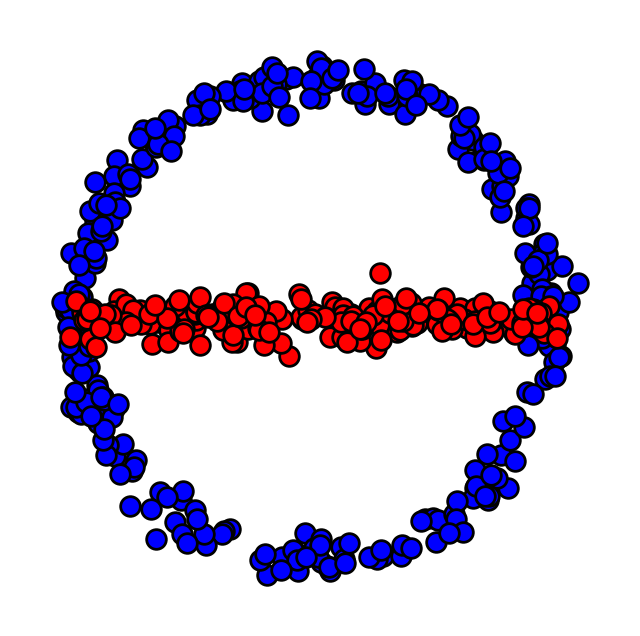

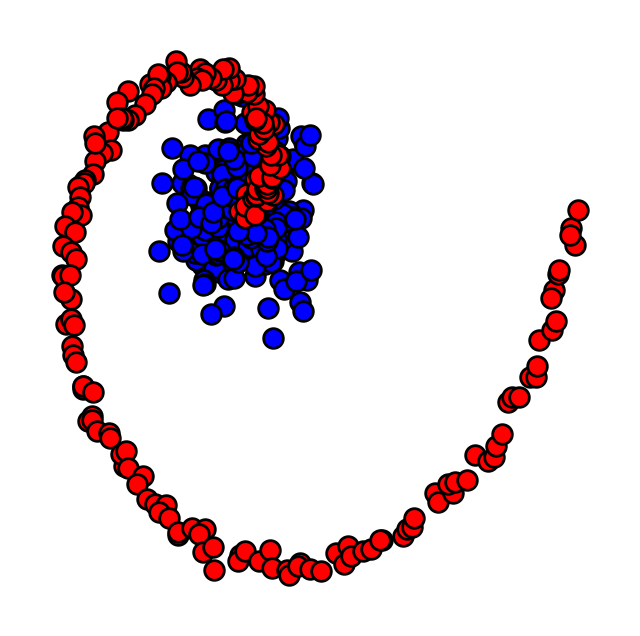

In [7]:
plot_data(X_1,Y_1)
plot_data(X_2,Y_2)

Cost matrix $C_{i,j} = \norm{x_i-y_j}^2$.

In [8]:
x2 = np.sum(X_1**2,0)
y2 = np.sum(Y_2**2,0)
C_1 = np.tile(y2,(N[0],1)) + np.tile(x2[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(X_1),Y_1)

x2_bis = np.sum(X_2**2,0)
y2_bis = np.sum(Y_2**2,0)
C_2 = np.tile(y2_bis,(N[0],1)) + np.tile(x2_bis[:,np.newaxis],(1,N[1])) - 2*np.dot(np.transpose(X_2),Y_2)

Target histograms $(a,b)$, here uniform histograms.

In [9]:
a = np.ones(N[0])/N[0]
b = np.ones(N[1])/N[1]

Regularization strength $\epsilon>0$.

In [10]:
epsilon = .01;

Gibbs Kernel $K$.

In [11]:
K_1 = np.exp(-C_1/epsilon)
K_2 = np.exp(-C_2/epsilon)

Initialization of $v=\mathcal{1}_{m}$ ($u$ does not need to be
initialized).

In [12]:
v_1 = np.ones(N[1])
v_2 = np.ones(N[1])

One sinkhorn iterations.

In [13]:
u_1 = a / (np.dot(K_1,v_1))
v_1 = b / (np.dot(np.transpose(K_1),u_1))

u_2 = a / (np.dot(K_2,v_2))
v_2 = b / (np.dot(np.transpose(K_2),u_2))

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_30589/568111320.py:2: RuntimeWarning: divide by zero encountered in divide
  v_1 = b / (np.dot(np.transpose(K_1),u_1))
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_30589/568111320.py:2: RuntimeWarning: overflow encountered in divide
  v_1 = b / (np.dot(np.transpose(K_1),u_1))


__Exercise 1__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$$ || P \mathbb{1} - a ||_1 \qandq || P^T \mathbb{1} - b || 
$$
(you need to think about how to compute these residuals from $(u,v)$ alone).
isplay the violation of constraint error in log-plot.

In [14]:
def sinkhorn(a,b,C,epsilon):
    epsilon = 0.01
    K = np.exp(-C / epsilon)
    v = np.ones(N[1])
    niter = 500
    Err_p = []
    Err_q = []

    for i in range(niter):
        # Sinkhorn step 1
        u = a / (np.dot(K, v) + 1e-16)
        # Error computation
        r = v * np.dot(np.transpose(K), u)
        Err_q.append(np.linalg.norm(r - b, 1))
        # Sinkhorn step 2
        v = b / (np.dot(np.transpose(K), u) + 1e-16)
        s = u * np.dot(K, v)
        Err_p.append(np.linalg.norm(s - a, 1))


    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(np.log(Err_p), color='blue', linewidth=2, linestyle='-', label=r"$\|P \mathbf{1} - a\|_1$")
    plt.title("Convergence of Constraint Errors", fontsize=14)
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Log Error", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(2, 1, 2)
    plt.plot(np.log(Err_q), color='red', linewidth=2, linestyle='-', label=r"$\|P^T \mathbf{1} - b\|_1$")
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Log Error", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


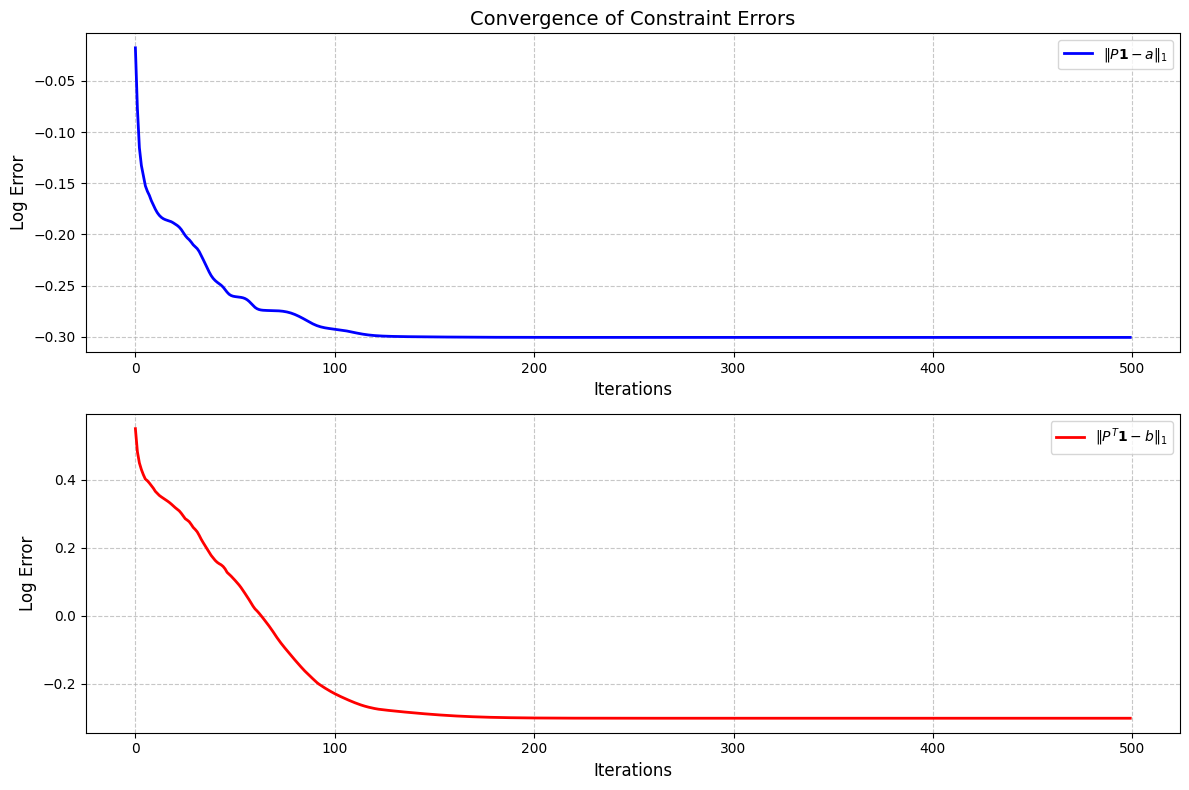

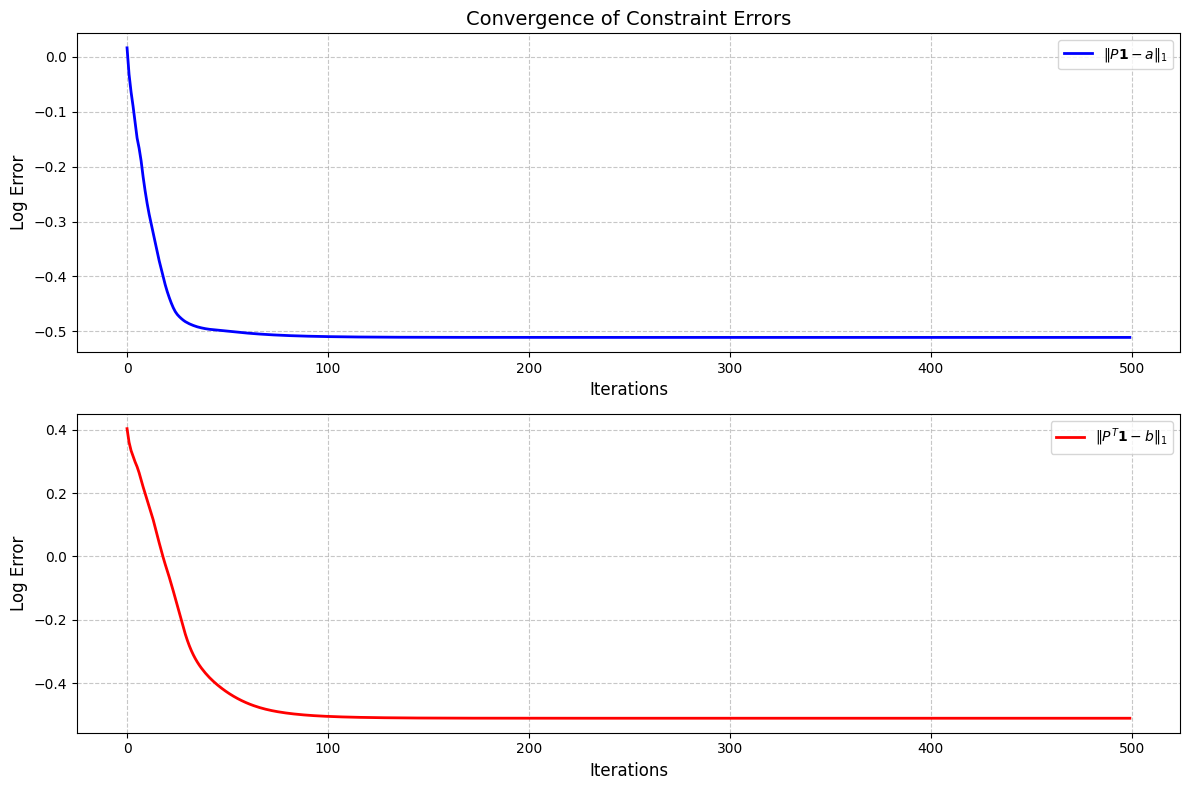

In [15]:
sinkhorn(a,b,C_1,epsilon)
sinkhorn(a,b,C_2,epsilon)

Compute the final matrix $P$.

In [16]:
P_1 = np.dot(np.dot(np.diag(u_1),K_1),np.diag(v_1))
P_2 = np.dot(np.dot(np.diag(u_2),K_2),np.diag(v_2))


Display it.

In [17]:
def plot_solution(P):
    plt.figure(figsize=(8, 6))
    plt.imshow(P, cmap='viridis', interpolation='nearest')

    plt.colorbar(label='Valeurs de P')
    plt.title("Solution du Problème régularisé avec le Sinkhorn Algorithm")

    plt.xlabel('Index Y')
    plt.ylabel('Index X')

    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

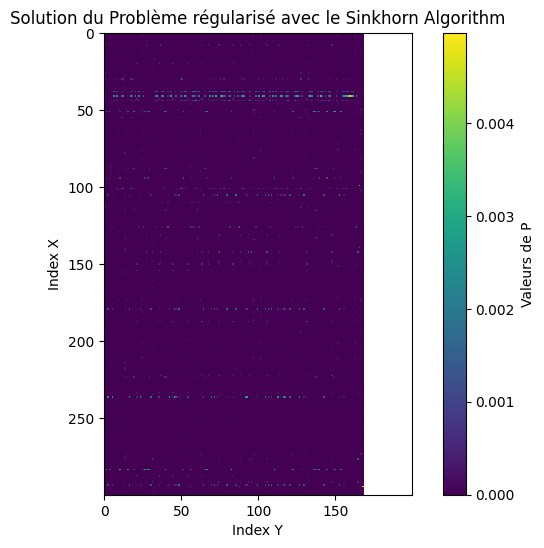

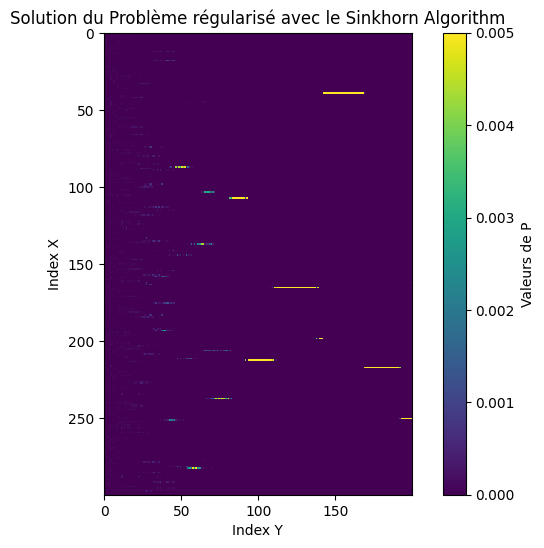

In [18]:
plot_solution(P_1)
plot_solution(P_2)

__Exercise 2__

Display the regularized transport solution for various values of $\epsilon$.
For a too small value of $\epsilon$, what do you observe ?

In [19]:
def plot_solution_reg(x, C):
    plt.figure(figsize = (10,10))
    glist = [.1,.01,.005,.002]
    niter = 300
    clamp = lambda x,a,b: min(max(x,a),b)
    list_sol = []
    for k in range(len(glist)):
        epsilon = glist[k]
        K = np.exp(-C/epsilon)
        v = np.ones(N[1])
        for i in range(niter):
            u = a / (np.dot(K,v) + 1e-16)
            v = b /(np.dot(np.transpose(K),u) + 1e-16)
        P = np.dot(np.dot(np.diag(u),K),np.diag(v))
        list_sol.append(P)
        #imageplot(clamp(Pi,0,np.min(1/np.asarray(N))*.3),"$\gamma=$ %.3f" %gamma, [2,2,k+1])
        plt.subplot(2,2,k+1)
        plt.imshow(np.clip(P,0,np.min(1/np.asarray(N))*.3));
        #"$\gamma=$ %.3f" %gamma, [2,2,k+1])
    return list_sol

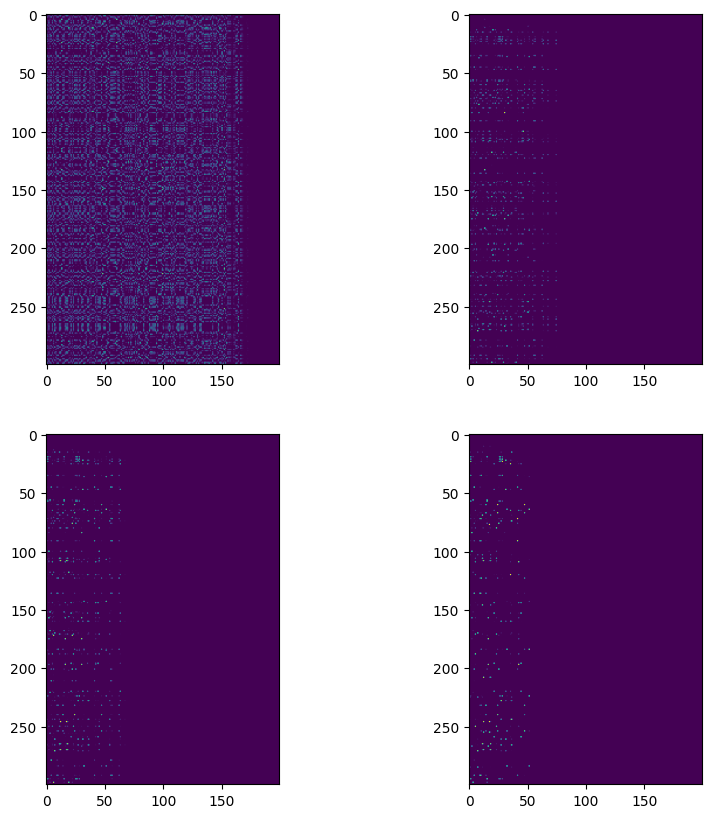

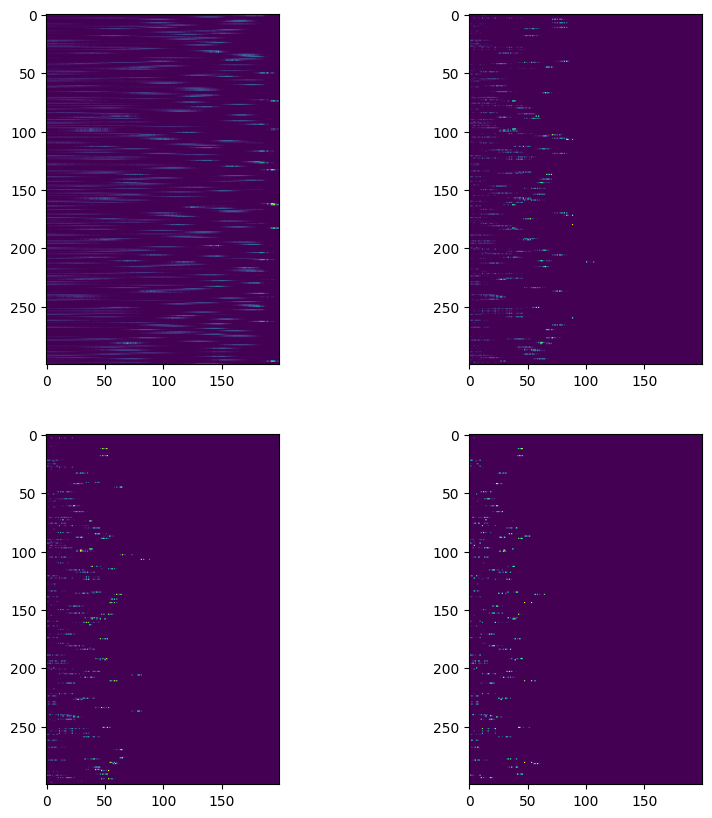

In [20]:
sol_1 = plot_solution_reg(X_1,C_1)
sol_2 = plot_solution_reg(X_2,C_2)

Keep only the highest entries of the coupling matrix, and use them to
draw a map between the two clouds.
First we draw "strong" connexions, i.e. linkds $(i,j)$ corresponding to
large values of $P_{i,j}$.
We then draw weaker connexions.

In [24]:
def plot_matching_multiple(X, Y, list_P):

    num_graphs = len(list_P)
    fig, axes = plt.subplots(1, num_graphs, figsize=(15, 5))

    if num_graphs == 1:
        axes = [axes]

    eps_list = [0.1, 0.01, 0.005, 0.002]
    
    for idx, (ax, P) in enumerate(zip(axes, list_P)):
        I, J = np.nonzero(P > 1e-5)

        for k in range(len(I)):
            ax.plot(
                np.hstack((X[0, I[k]], Y[0, J[k]])),
                np.hstack((X[1, I[k]], Y[1, J[k]])),
                'k', lw=1
            )

        ax.scatter(X[0, :], X[1, :], color='blue', label='X')
        ax.scatter(Y[0, :], Y[1, :], color='red', label='Y')

        all_x = np.concatenate([X[0, :], Y[0, :]])
        all_y = np.concatenate([X[1, :], Y[1, :]])
        x_min, x_max = all_x.min() - 0.1 * abs(all_x.ptp()), all_x.max() + 0.1 * abs(all_x.ptp())
        y_min, y_max = all_y.min() - 0.1 * abs(all_y.ptp()), all_y.max() + 0.1 * abs(all_y.ptp())
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

        ax.set_title(f"Solution for epsilon = {eps_list[idx]}", fontsize=12)
        ax.axis('off')

    plt.tight_layout()
    plt.show()


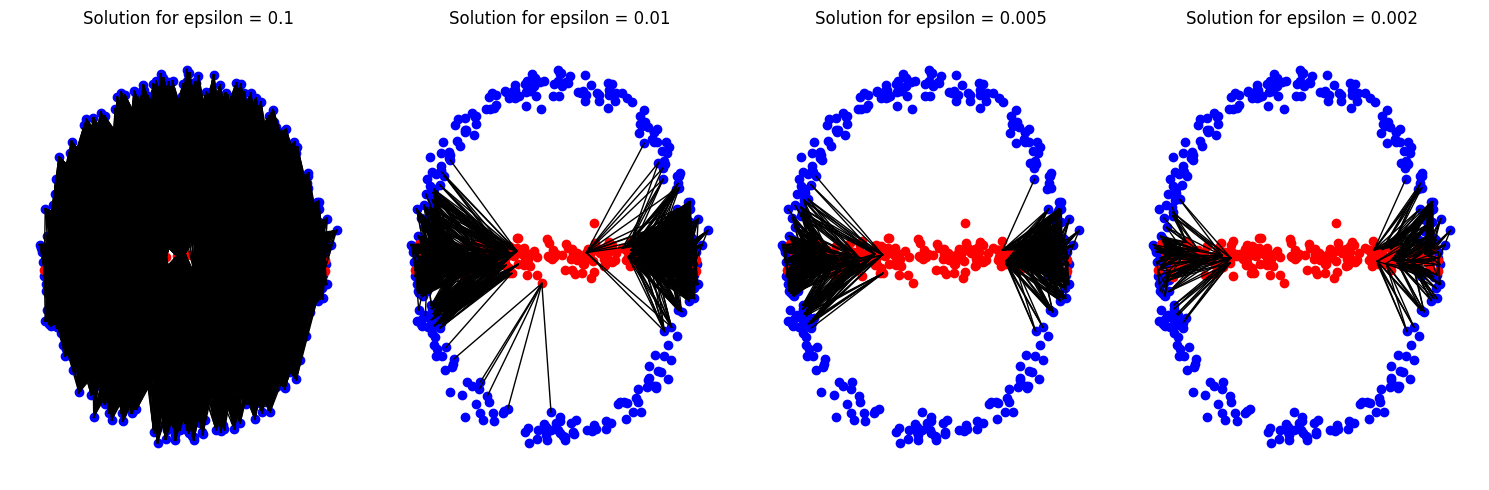

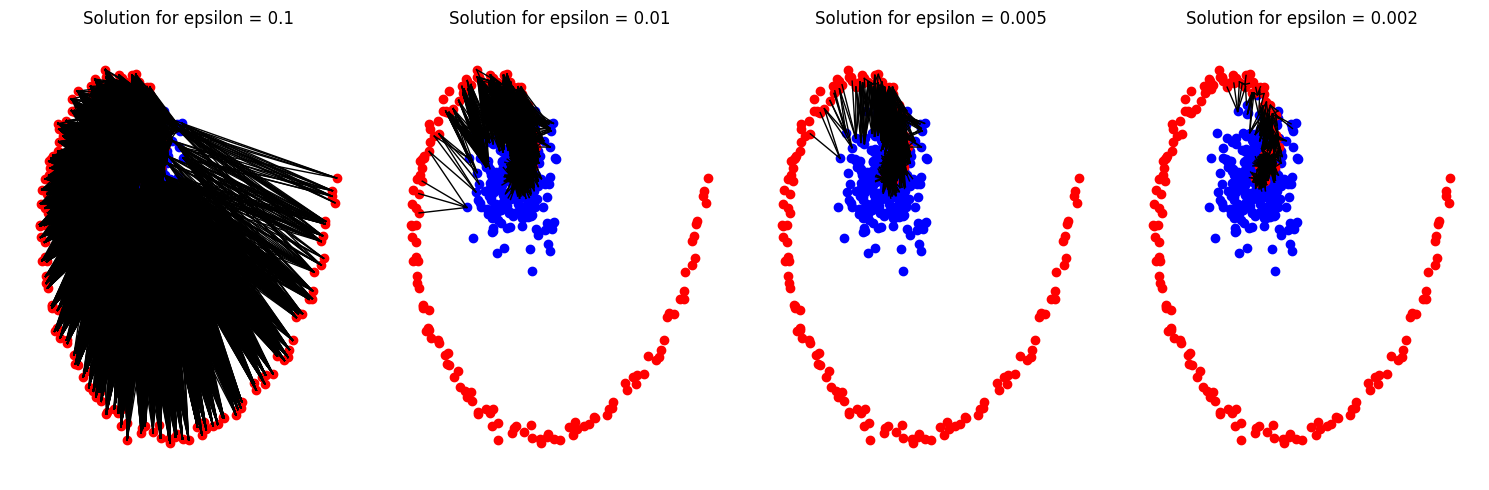

In [25]:
plot_matching_multiple(X_1,Y_1, sol_1)
plot_matching_multiple(X_2,Y_2, sol_2)

Transport Between Histograms
----------------------------
We now consider a different setup, where the histogram values
$a,b$ are not uniform, but the measures are defined on a uniform grid
$x_i=y_i=i/n$. They are thue often refered to as "histograms".


Size $n$ of the histograms.

In [6]:
N = 200

We use here a 1-D square Euclidean metric.

In [7]:
t = np.arange(0,N)/N

Define the histogram $a,b$ as translated Gaussians.

In [8]:
Gaussian_mixt = lambda t0,sigma,w: w[0]*np.exp(-(t-t0[0])**2/(2*sigma[0]**2)) + w[1]*np.exp(-(t-t0[1])**2/(2*sigma[1]**2))
normalize = lambda p: p/np.sum(p)
sigma_1 = [.06, 0.1];
t0_1 = [0.3,0.6]
sigma_2 = [.05, 0.05];
t0_2 = [0.1,0.7]
a = Gaussian_mixt(t0_1,sigma_1,[.5,.5])
b = Gaussian_mixt(t0_2,sigma_2,[.5,.5])

Add some minimal mass and normalize.

In [9]:
vmin = .02;
a = normalize( a+np.max(a)*vmin)
b = normalize( b+np.max(b)*vmin)

Display the histograms.

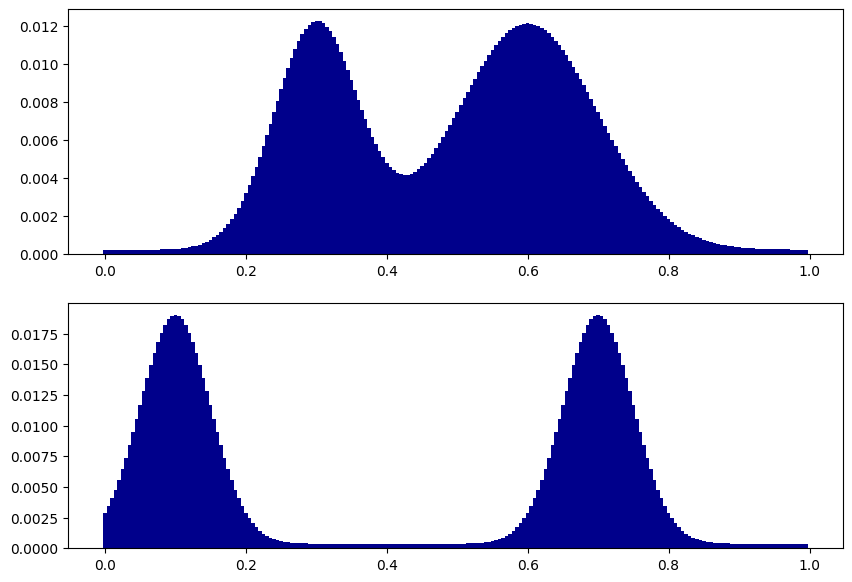

In [10]:
plt.figure(figsize = (10,7))
plt.subplot(2, 1, 1)
plt.bar(t, a, width = 1/len(t), color = "darkblue")
plt.subplot(2, 1, 2)
plt.bar(t, b, width = 1/len(t), color = "darkblue")
plt.show()

Regularization strength $\ga$.

In [11]:
epsilon = (.03)**2

The Gibbs kernel is a Gaussian convolution,
$ K_{i,j} \eqdef e^{ -(i/N-j/N)^2/\epsilon }. $

In [12]:
[Y,X] = np.meshgrid(t,t)
K = np.exp(-(X-Y)**2/epsilon)

Initialization of $v=\mathbb{1}_{N}$.

In [13]:
v = np.ones(N)

One sinkhorn iteration.

In [14]:
u = a / (np.dot(K,v))
v = b / (np.dot(np.transpose(K),u))

__Exercise 3__

Implement Sinkhorn algorithm.
Display the evolution of the constraints satisfaction errors
$$ || P \mathbb{1} - a ||_1 \qandq || P^T \mathbb{1} - b || 
$$
(you need to think about how to compute these residuals from $(u,v)$ alone).
isplay the violation of constraint error in log-plot.

In [15]:
def sinkhorn_error_plot(a, b, K, niter=2000):

    v = np.ones(K.shape[1])
    Err_p = []
    Err_q = []

    for i in range(niter):
        # Étape Sinkhorn 1
        u = a / np.dot(K, v)

        # Calcul de l'erreur des contraintes
        r = v * np.dot(K.T, u)
        Err_q.append(np.linalg.norm(r - b, 1))

        # Étape Sinkhorn 2
        v = b / np.dot(K.T, u)
        s = u * np.dot(K, v)
        Err_p.append(np.linalg.norm(s - a, 1))

    plt.figure(figsize=(8, 6))

    plt.subplot(2, 1, 1)
    plt.plot(np.log(Err_p), color="blue", linewidth=2, label="$||P1 - a||_1$")
    plt.title("Évolution de $||P1 - a||_1$", fontsize=14, pad=10)
    plt.xlabel("Itérations", fontsize=12)
    plt.ylabel("Erreur (log-scale)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)

    plt.subplot(2, 1, 2)
    plt.plot(np.log(Err_q), color="red", linewidth=2, label="$||P^T1 - b||_1$")
    plt.title("Évolution de $||P^T1 - b||_1$", fontsize=14, pad=10)
    plt.xlabel("Itérations", fontsize=12)
    plt.ylabel("Erreur (log-scale)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

    return u, v

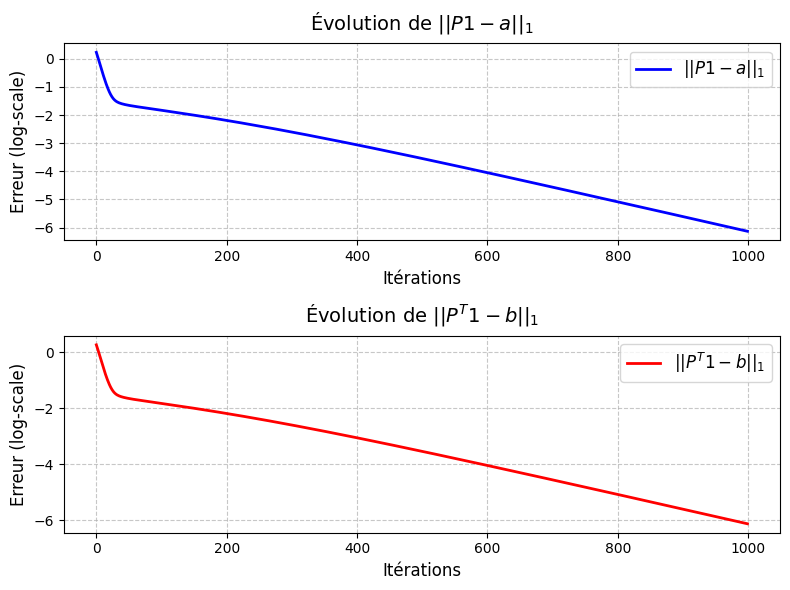

In [16]:
u, v = sinkhorn_error_plot(a, b, K, niter=1000)

Display the coupling. Use a log domain plot to better vizualize it.

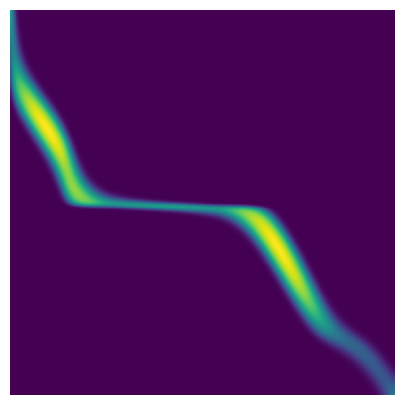

In [17]:
P = np.dot(np.dot(np.diag(u),K),np.diag(v))
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.axis('off');

One can compute an approximation of the transport plan
between the two measure by computing the so-called barycentric projection map
$ t_i \in [0,1] \longmapsto s_j \eqdef \frac{\sum_{j} P_{i,j} t_j }{ \sum_{j} P_{i,j} }
   =  \frac{ [u \odot K(v \odot t)]_j }{ a_i }. $
where $\odot$ and $\frac{\cdot}{\cdot}$ are the enry-wise multiplication and division.


This computation can thus be done using only multiplication with the
kernel $K$.

In [18]:
s = np.dot(K,v*t)*u/a

Display the transport map, super-imposed over the coupling.

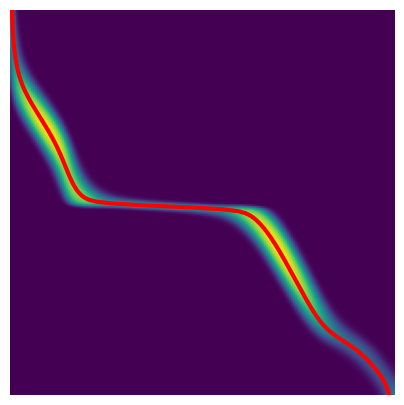

In [19]:
plt.figure(figsize=(5,5))
plt.imshow(np.log(P+1e-5))
plt.plot(s*N,t*N, 'r', linewidth=3);
plt.axis('off');

__Exercise (bonus)__

Try different regularization strength $\epsilon$.

In [38]:
def sinkhorn_error_plot_multiple(cost_matrices, niter=10000):
    """
    Trace les erreurs de Sinkhorn pour plusieurs matrices de coûts sur le même graphique.

    Parameters:
    -----------
    cost_matrices : list of tuples
        Liste de triplets (a, b, K), où :
        - a : ndarray (n,) - Distribution source.
        - b : ndarray (m,) - Distribution cible.
        - K : ndarray (n, m) - Matrice de coût exponentielle.
    niter : int
        Nombre d'itérations de Sinkhorn (par défaut : 2000).
    """
    plt.figure(figsize=(12, 8))

    # Palette de couleurs
    colors = plt.cm.tab10(np.linspace(0, 1, len(cost_matrices)))

    for idx, (a, b, K, eps) in enumerate(cost_matrices):
        v = np.ones(K.shape[1])
        Err_p, Err_q = [], []

        for i in range(niter):
            # Étape Sinkhorn 1
            u = a / np.dot(K, v)

            # Calcul des erreurs des contraintes
            r = v * np.dot(K.T, u)
            Err_q.append(np.linalg.norm(r - b, 1))

            # Étape Sinkhorn 2
            v = b / np.dot(K.T, u)
            s = u * np.dot(K, v)
            Err_p.append(np.linalg.norm(s - a, 1))

        # Tracer les erreurs pour ce triplet
        plt.plot(
            np.log(Err_p), 
            color=colors[idx], 
            linewidth=2, 
            linestyle="-", 
            label=f"$||P1 - a||_1$ (epsilon = {eps})"
        )
        plt.plot(
            np.log(Err_q), 
            color=colors[idx], 
            linewidth=2, 
            linestyle="--", 
            label=f"$||P^T1 - b||_1$ (epsilon = {eps})"
        )

    # Améliorations esthétiques
    plt.title("Evolution of Constraints Errors of Sinkhorn Algorithm for Different Regularization Intensities", fontsize=16, pad=15)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Constraints Error (log-scale)", fontsize=14)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(fontsize=12, loc="best", ncol=2, frameon=True, framealpha=0.9)
    plt.tight_layout()
    plt.show()


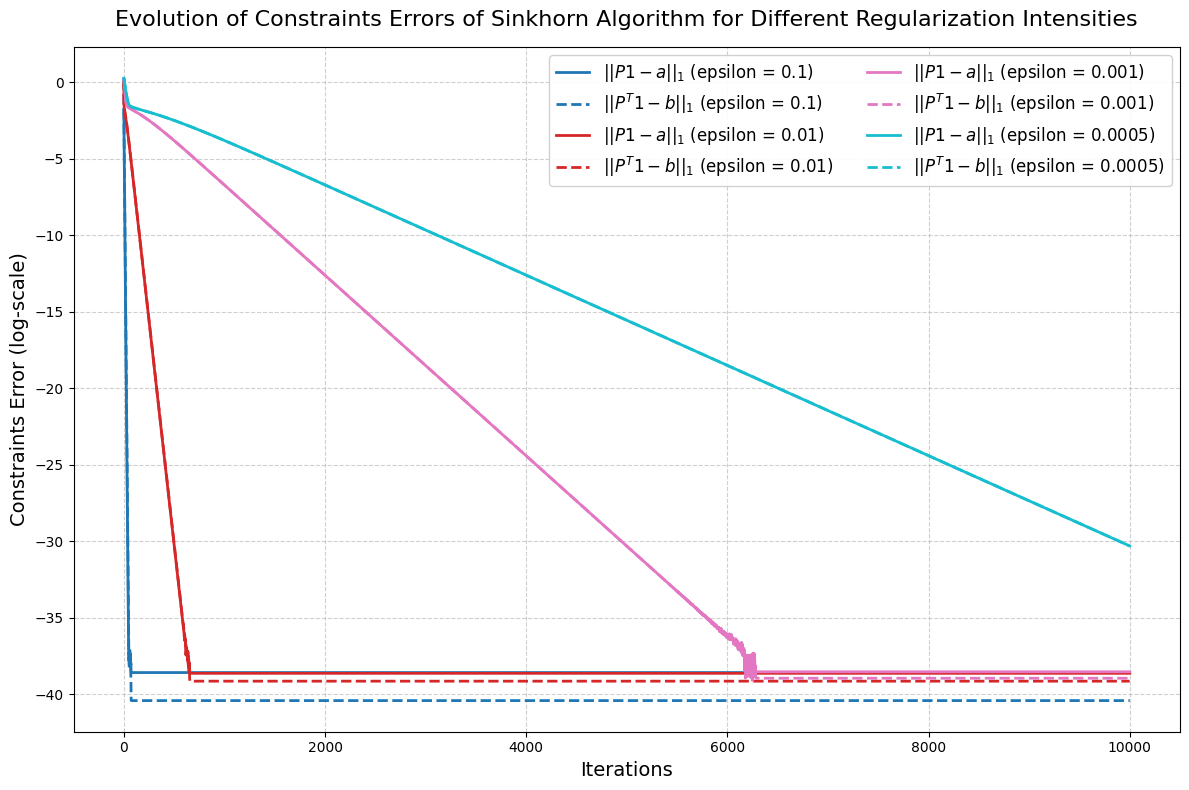

In [39]:
epsilons = [0.1, 0.01, 0.001, 0.0005]
K_list = []
for eps in epsilons:
    [Y,X] = np.meshgrid(t,t)
    K_list.append((a, b, np.exp(-(X-Y)**2/eps), eps))

sinkhorn_error_plot_multiple(K_list)

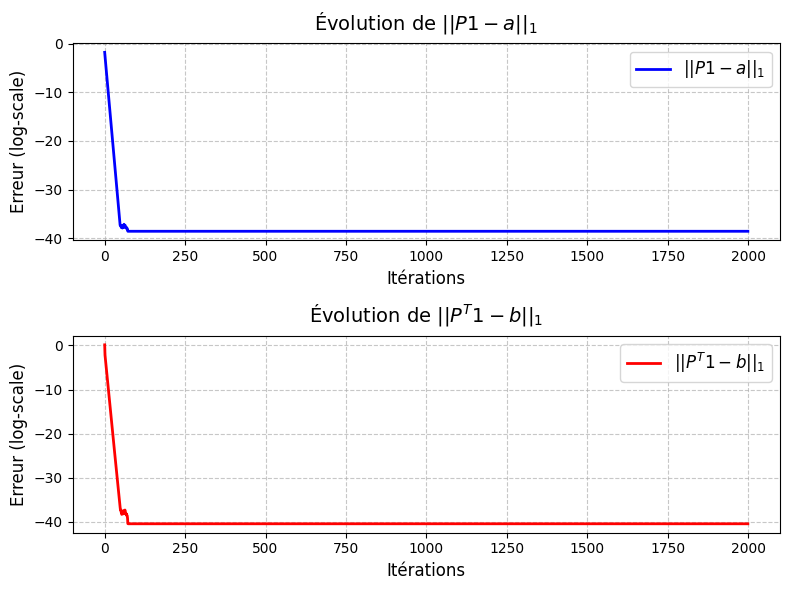

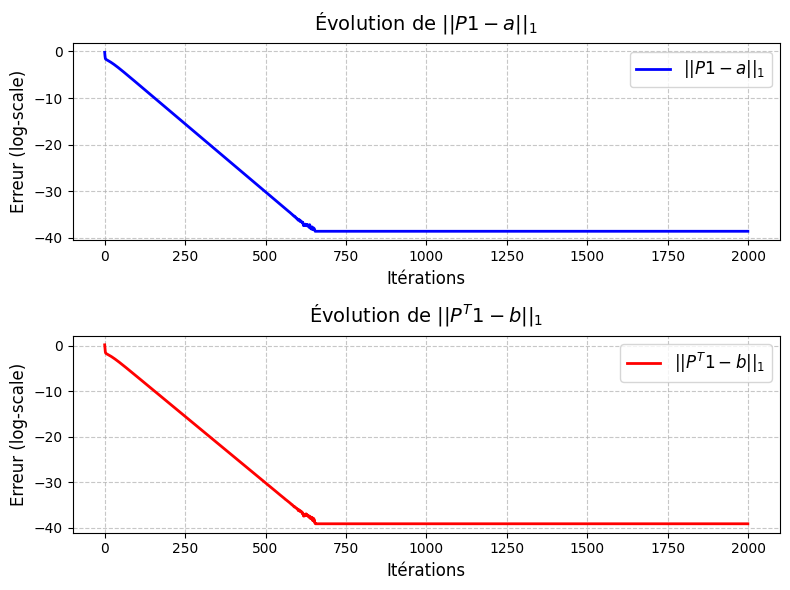

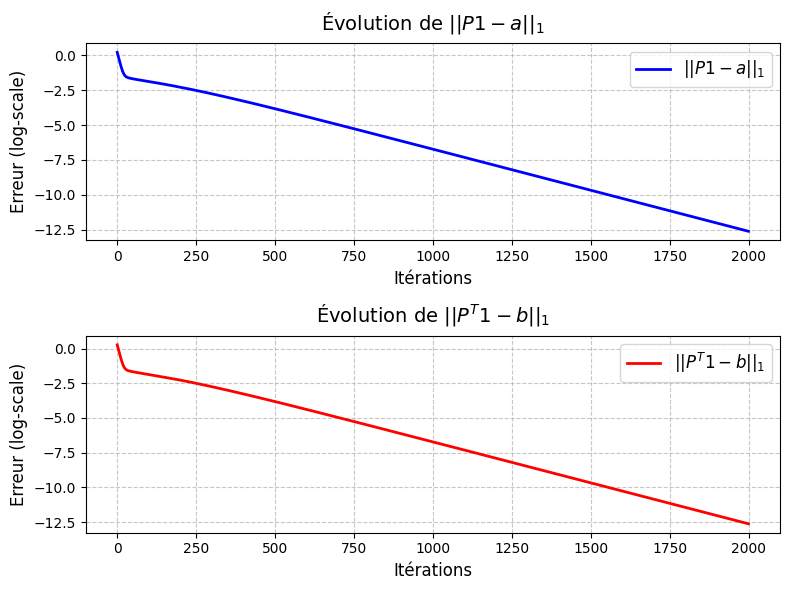

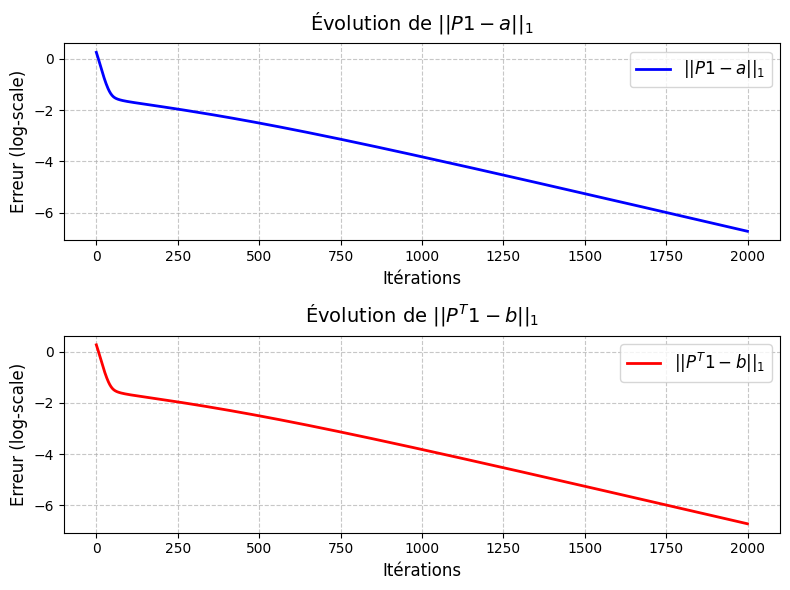

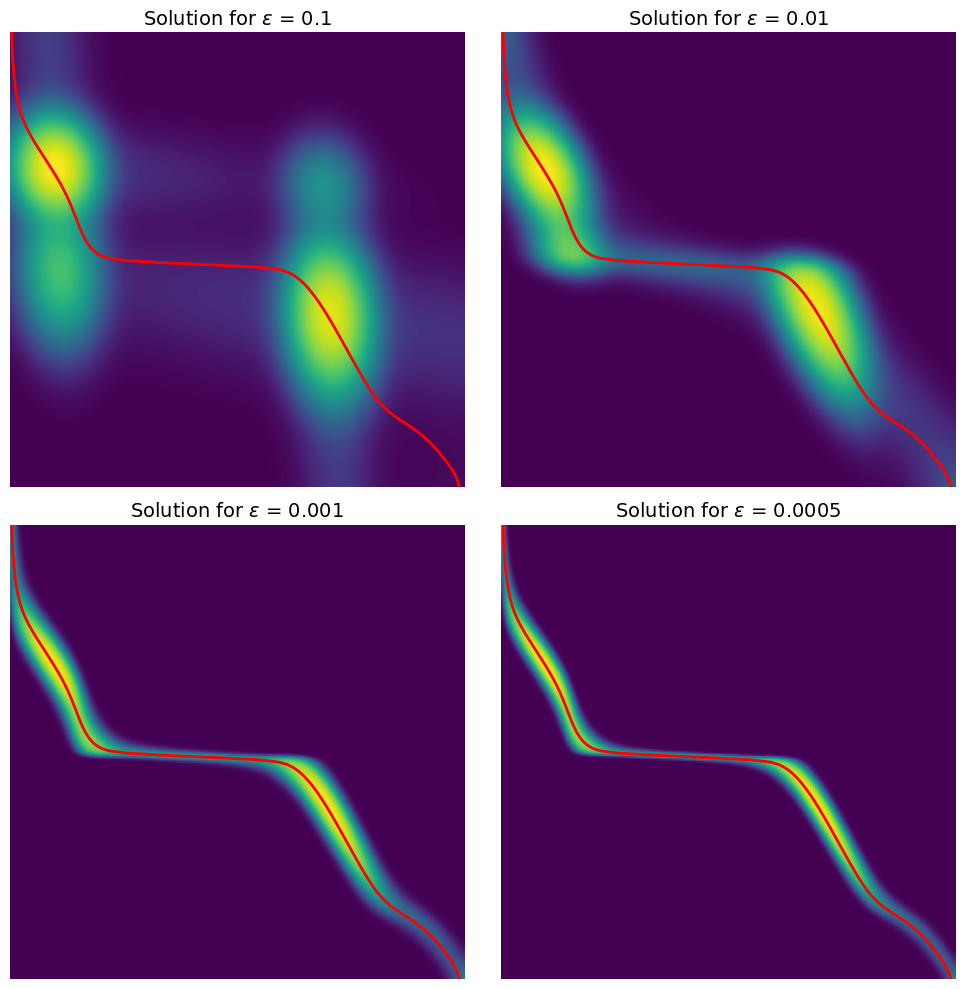

In [22]:
epsilons = [0.1, 0.01, 0.001, 0.0005]
P_liste = []

for eps in epsilons:
    [Y,X] = np.meshgrid(t,t)
    K = np.exp(-(X-Y)**2/eps)
    u, v = sinkhorn_error_plot(a, b, K)
    s = np.dot(K,v*t)*u/a
    P_liste.append(np.dot(np.dot(np.diag(u),K),np.diag(v)))

n_plots = len(P_liste)
n_cols = min(n_plots, 2)  # Nombre de colonnes (3 max par ligne)
n_rows = -(-n_plots // n_cols)  # Calcul du nombre de lignes

plt.figure(figsize=(5 * n_cols, 5 * n_rows))

for i, (P, eps) in enumerate(zip(P_liste, epsilons)):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(np.log(P + 1e-5), cmap="viridis")
    plt.plot(s * N, t * N, 'r', linewidth=2)
    plt.axis('off')
    plt.title(f"Solution for $\\epsilon$ = {eps}", fontsize=14)

plt.tight_layout()
plt.show()

Using GPUs
-----------------------

We will use here [Pytorch](https://pytorch.org/) to implement Sinkhorn on the GPU. If you are running the code on Google Colab, this means you need to switch on in the preferences the use of a GPU.

In [85]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print( device )

cpu


Since CUDA uses float number on 32 bits, one needs to use a quite large value for $\epsilon$ to avoid overflow.

In [86]:
epsilon = (.06)**2
K = np.exp(-(X-Y)**2/epsilon)

Convert Sinkohrn variables and host them on GPU (if available).

In [87]:
u = torch.ones(N);
v = torch.ones(N);
K1 = torch.from_numpy(K).type(torch.FloatTensor); 
a1 = torch.from_numpy(a).type(torch.FloatTensor); 
b1 = torch.from_numpy(b).type(torch.FloatTensor); 
K1.to(device);
u.to(device); v.to(device);
a1.to(device); b1.to(device);

When using Pytorch, it is good practice to implement matrix operation as summation and dummy variables.  We show here how to implement one iteration of Sinkhorn this way.

In [88]:
u = a1 / (K1 * v[None,:]).sum(1)
v = b1 / (K1 * u[:,None]).sum(0)

__Exercise:__

Implement the full algorithm.

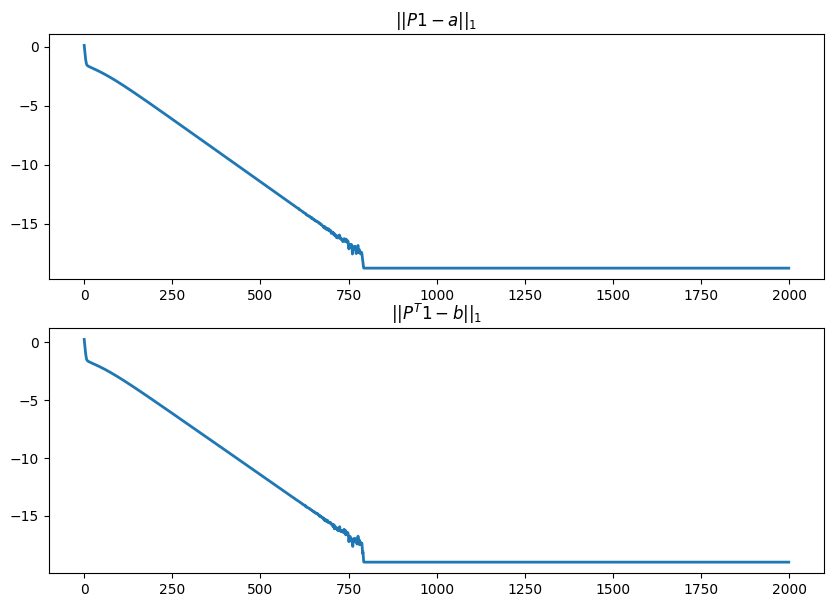

In [89]:
v = torch.ones(N)
niter = 2000
Err_p = torch.zeros(niter)
Err_q = torch.zeros(niter)
for i in range(niter):
    # sinkhorn step 1
    u = a1 / (K1 * v[None,:]).sum(1)    
    # error computation
    r = v*(K1 * u[:,None]).sum(0)
    Err_q[i] = torch.norm(r - b1, p=1)
    # sinkhorn step 2
    v = b1 / (K1 * u[:,None]).sum(0)
    s = u*(K1 * v[None,:]).sum(1)
    Err_p[i] = torch.norm(s - a1,p=1)
plt.figure(figsize = (10,7))
plt.subplot(2,1,1)
plt.title("$||P1 -a||_1$")
plt.plot(np.log(np.asarray(Err_p)), linewidth = 2)
plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
plt.plot(np.log(np.asarray(Err_q)), linewidth = 2)
plt.show()

__Exercice__
To avoid underflow, replace the matrix/vector multiplication in a log-sum-exp style, and use the log-sum-exp stabilization trick.

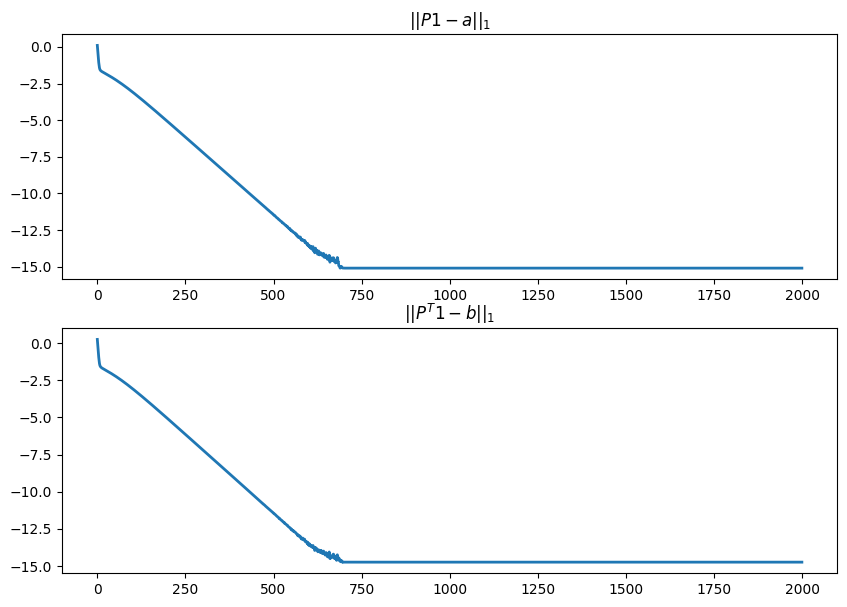

In [91]:
log_u = torch.zeros(N, device=device)  
log_v = torch.zeros(N, device=device)  
log_K = torch.log(K1)

niter = 2000
Err_p = torch.zeros(niter, device=device)
Err_q = torch.zeros(niter, device=device)

for i in range(niter):
    log_u = torch.log(a1) - torch.logsumexp(log_K + log_v[None, :], dim=1)

    r_log = log_v + torch.logsumexp(log_K.T + log_u[:, None], dim=0)  # log(r)
    Err_q[i] = torch.norm(torch.exp(r_log) - b1, p=1)

    log_v = torch.log(b1) - torch.logsumexp(log_K.T + log_u[:, None], dim=0)

    s_log = log_u + torch.logsumexp(log_K + log_v[None, :], dim=1)  # log(s)
    Err_p[i] = torch.norm(torch.exp(s_log) - a1, p=1)

plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.title("$||P1 - a||_1$")
plt.plot(np.log(Err_p.cpu().numpy()), linewidth=2)
plt.subplot(2, 1, 2)
plt.title("$||P^T 1 - b||_1$")
plt.plot(np.log(Err_q.cpu().numpy()), linewidth=2)
plt.show()


Wasserstein Barycenters
-----------------------
Instead of computing transport, we now turn to the problem of computing
barycenter of $R$ input measures $(a_k)_{k=1}^R$. A barycenter $b$ solves
$ \umin{b} \sum_{k=1}^R \lambda_k W_\ga(a_k,b)  $
where $\la_k$ are positive weights with $\sum_k \la_k=1$. This
follows the definition of barycenters proposed in
[AguehCarlier](#biblio).

Dimension (width of the images) $N$ of the histograms.

In [159]:
N = 100

You need to install imageio, for instance using
> conda install -c conda-forge imageio

If you need to rescale the image size, you can use
> skimage.transform.resize

Load input histograms $(a_k)_{k=1}^R$, store them in a tensor $A$. On y ajoute nos propres images que l'on resize de manière égale. 

In [160]:
base_path = "https://raw.githubusercontent.com/gpeyre/numerical-tours/master/python/nt_toolbox/data/"
rescale = lambda x: (x-x.min())/(x.max()-x.min())
vmin = .01
R = 4
A = np.zeros([N,N,R])
a = imageio.imread(base_path + 'disk' + ".bmp") # ,N) 
a = normalize(rescale(a)+vmin)
a = resize(a, [N,N])
A[:,:,0] = a

psg = imageio.imread("PSG.png")
psg = psg[:,:,0]
psg = normalize(rescale(psg)+vmin)
psg = resize(psg, [N,N])
A[:,:,1] = psg

arsenal = imageio.imread("Arsenal.png")
arsenal = arsenal[:,:,0]
arsenal = normalize(rescale(arsenal)+vmin)
arsenal = resize(arsenal, [N,N])
A[:,:,2] = arsenal

om = imageio.imread("OM.png")
om = om[:,:,0]
om = normalize(rescale(om)+vmin)
om = resize(om, [N,N])
A[:,:,3] = om

/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_30589/1027339512.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  a = imageio.imread(base_path + 'disk' + ".bmp") # ,N)
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_30589/1027339512.py:11: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  psg = imageio.imread("PSG.png")
/var/folders/sg/lxw89kss0x727nlhml9vq0nm0000gn/T/ipykernel_30589/1027339512.py:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning

Display the input histograms.

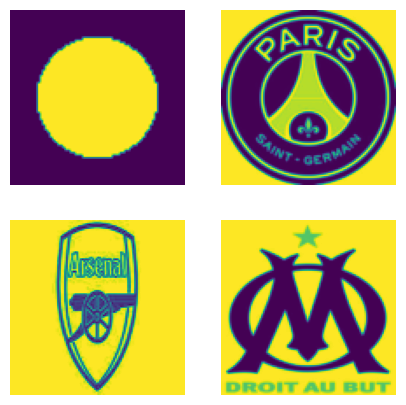

In [161]:
plt.figure(figsize=(5,5))
for i in range(R):
    plt.subplot(2,2,i+1)
    plt.imshow(A[:,:,i])
    plt.axis('off');

In this specific case, the kernel $K$ associated with the
squared Euclidean norm is a convolution with a Gaussian filter
$ K_{i,j} = e^{ -\norm{i/N-j/N}^2/\epsilon } $
where here $(i,j)$ are 2-D indexes.


The multiplication against the kernel, i.e. $K(a)$, 
can now be computed efficiently, using fast convolution methods. 
This crucial points was exploited and generalized in [SolomonEtAl](#biblio)
to design fast optimal transport algorithm.

Regularization strength $\epsilon>0$. On adapte la valeur de $\epsilon$ pour nos images particulières. 

In [182]:
epsilon = (.01)**2

Define the $K$ kernel.
We use here the fact that the convolution is separable to implement it
using only 1-D convolution, which further speeds up computations.

In [183]:
t = np.linspace(0,1,N)
[Y,X] = np.meshgrid(t,t)
K1 = np.exp(-(X-Y)**2/epsilon)
K = lambda x: np.dot(np.dot(K1,x),K1)

Display the application of the $K$ kernel on one of the input histogram.

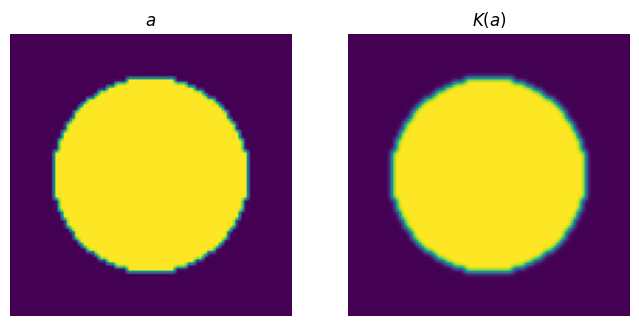

In [184]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(A[:,:,0])
plt.title("$a$")
plt.axis('off');
plt.subplot(1,2,2)
plt.imshow(K(A[:,:,0]))
plt.title("$K(a)$")
plt.axis('off');

Weights $\la_k$ for isobarycenter.

In [185]:
lambd = np.ones(R)/R

It is shown in [BenamouEtAl](#biblio) that the problem of Barycenter computation
boilds down to
optimizing over couplings $(P_k)_{k=1}^R$, and that this can be achieved
using iterative a Sinkhorn-like algorithm, since the optimal coupling has the scaling form
$P_k = \diag{u_k} K \diag{v_k}$
for some unknown positive weights $(u_k,v_k)$.

Initialize the scaling factors $(u_k,v_k)_k$, store them in matrices.

In [186]:
v = np.ones([N,N,R])
u = np.copy(v)

The first step of the Bregman projection method corresponds to the
projection on the fixed marginals constraints $P^k \mathbb{1} = a_k$. This
is achieved by updating
$ \forall k=1,\ldots,R, \quad u_k \longleftarrow \frac{a_k}{ K( v_k ) }. $

In [187]:
for k in range(R):
    u[:,:,k] = A[:,:,k]/K(v[:,:,k])

The second step of the Bregman projection method corresponds to the
projection on the equal marginals constraints $\forall k, P_k^T \mathbb{1}=b$ for a common barycenter target $b$. This
is achieved by first computing the target barycenter $b$ using a geometric means
$ \log(b) \eqdef \sum_k \lambda_k \log( u_{k} \odot K ( v_{k} ) ). $

In [188]:
b = np.zeros(N)
for k in range(R):
    b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
b = np.exp(b)

Display $b$.

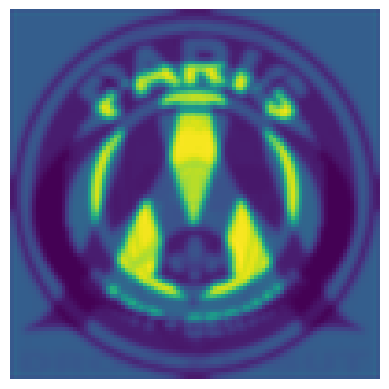

In [189]:
plt.imshow(b);
plt.axis('off');

And then one can update the scaling by a Sinkhorn step using this newly computed histogram $b$ as follow (note that $K=K^\top$ here):
$ \forall k=1,\ldots,R, \quad v_{k} \longleftarrow \frac{b}{ K(u_{k}) }. $

In [190]:
for k in range(R):
    v[:,:,k] = b/K(u[:,:,k])

__Exercise 4__

Implement the iterative algorithm to compute the iso-barycenter of the measures.
Plot the decay of the error $\sum_k ||P_k \mathbb{1} - a_k|| $.

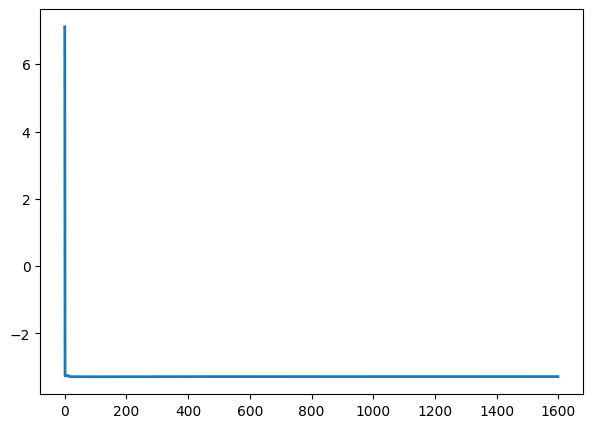

In [191]:
niter = 1600
v = np.ones([N,N,R])
u = np.copy(v)
Err_q = np.zeros(niter)
for i in range(niter):
    for k in range(R):
        Err_q[i] = Err_q[i] + np.linalg.norm(u[:,:,k]*K(v[:,:,k]) - A[:,:,k], 1)
        u[:,:,k] = A[:,:,k]/(K(v[:,:,k]) + 1e-19)
    b = np.zeros(N)
    for k in range(R):
        b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
    b = np.exp(b)
    for k in range(R):
        v[:,:,k] = b/(K(u[:,:,k]) + 1e-19)
plt.figure(figsize=(7,5))
plt.plot(np.log(Err_q),linewidth = 2)
plt.show()

Display the barycenter.

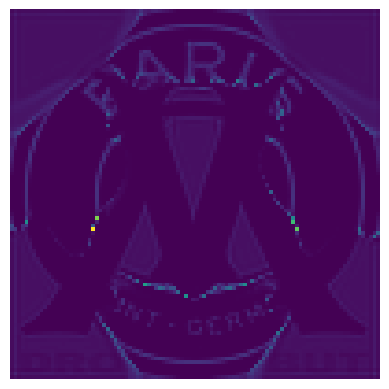

In [192]:
plt.imshow(b)
plt.axis('off');

__Exercise 5__

Compute barycenters for varying weights $\la$ corresponding to
a bilinear interpolation inside a square.

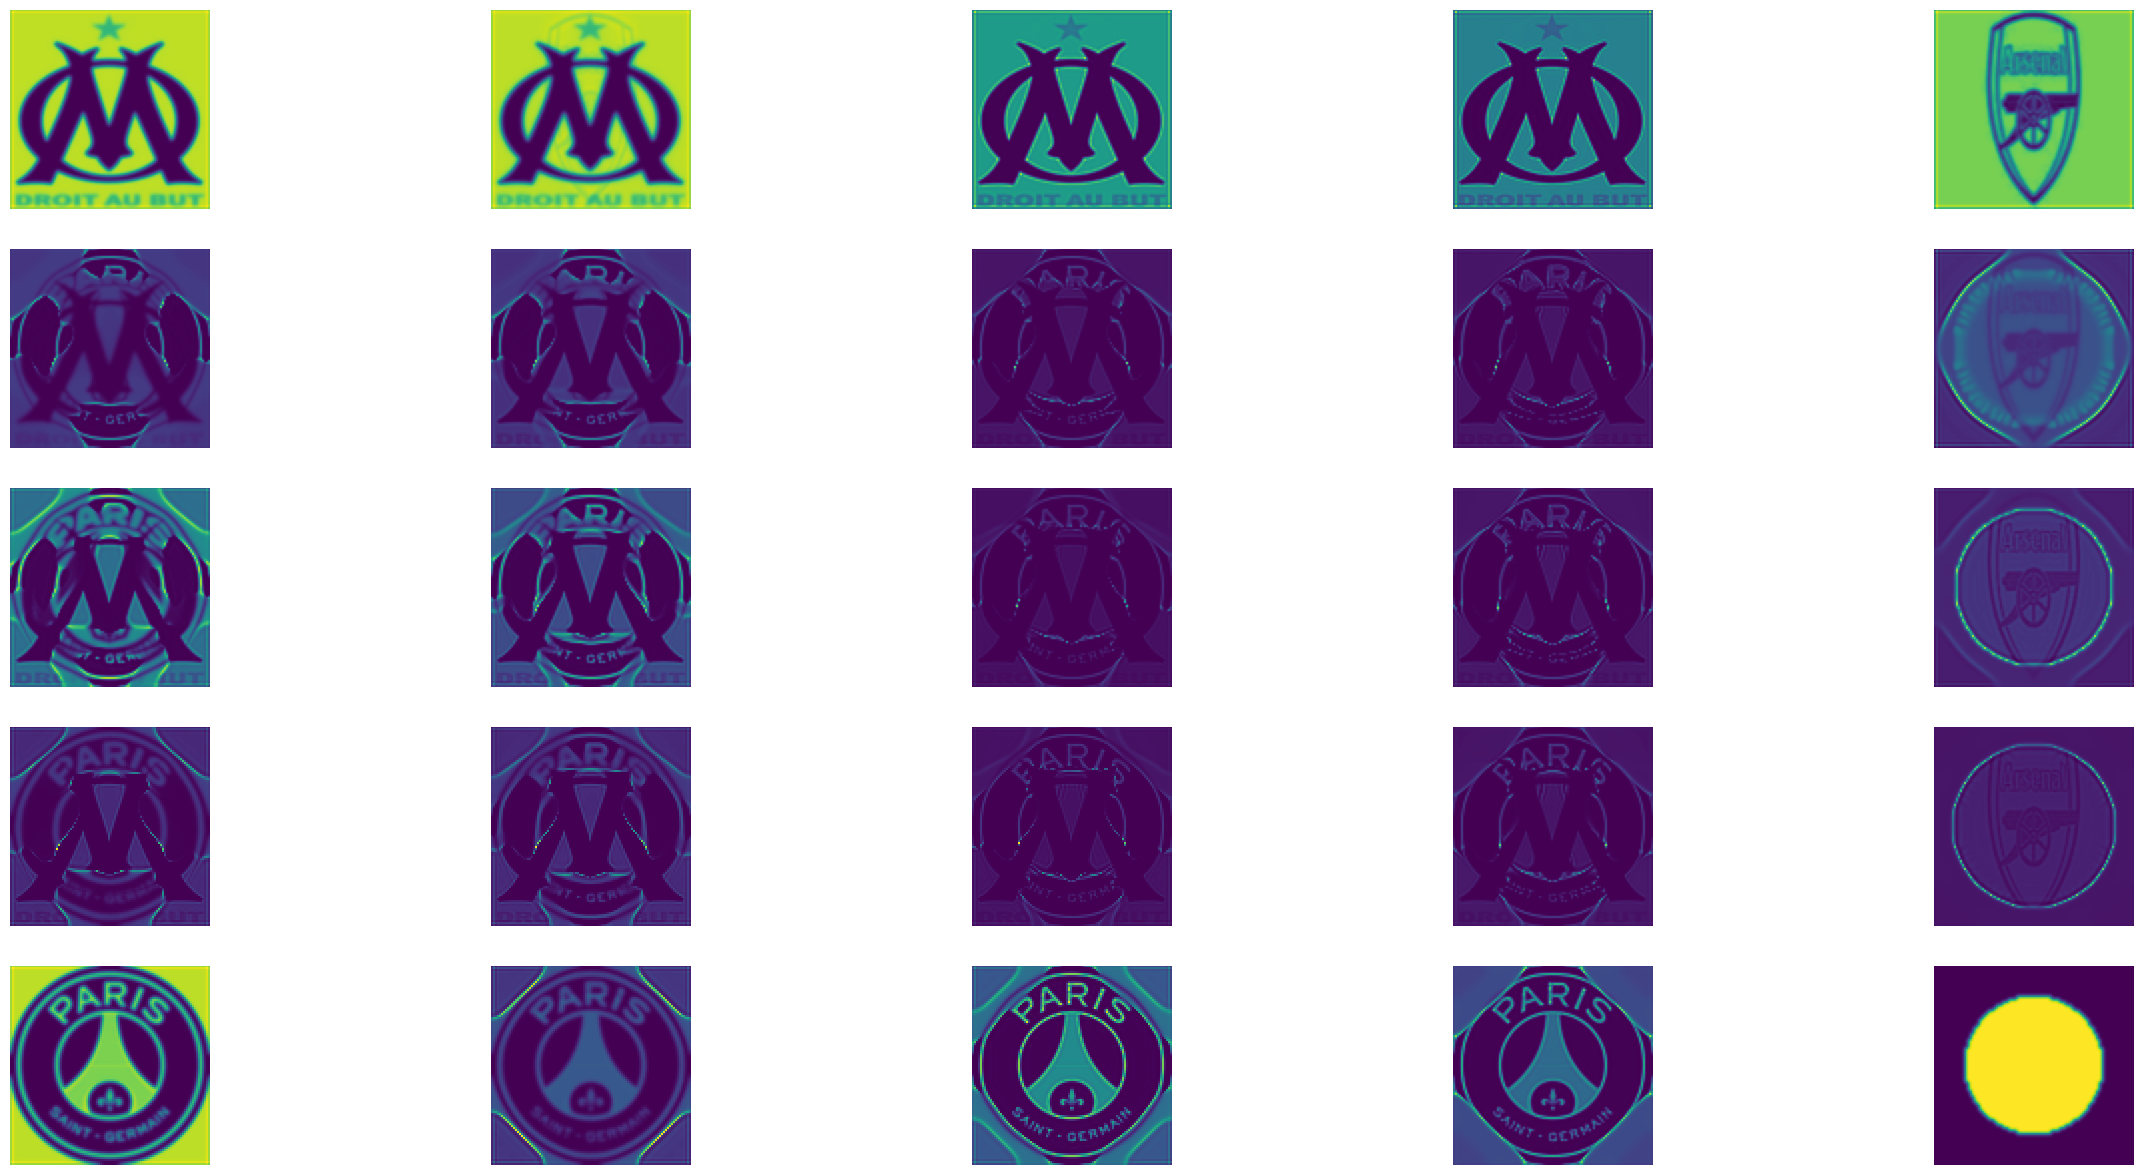

In [193]:
m = 5
[T,S] = np.meshgrid(np.linspace(0,1,m), np.linspace(0,1,m))
T = np.ravel(T,order="F")
S = np.ravel(S,order="F")
niter = 1000
plt.figure(figsize=(30,15))
for j in range(m**2):
    # weights
    lambd = np.hstack((S[j]*T[j], (1-S[j])*T[j], S[j]*(1-T[j]), (1-S[j])*(1-T[j])))
    # computation
    v = np.ones([N,N,R])
    u = np.copy(v)
    for i in range(niter):
        for k in range(R):
            u[:,:,k] = A[:,:,k]/(K(v[:,:,k]) + 1e-19)
        b = np.zeros(N)
        for k in range(R):
            b = b + lambd[k] * np.log(np.maximum(1e-19*np.ones(len(v[:,:,k])), v[:,:,k]*K(u[:,:,k])))
        b = np.exp(b)
        for k in range(R):
            v[:,:,k] = b/(K(u[:,:,k]) + 1e-19)
    # display
    plt.subplot(m,m,j+1)
    plt.imshow(b)
    plt.axis('off')

Bibliography
------------
<html><a name="biblio"></a></html>


* [Villani] C. Villani, (2009). Optimal transport: old and new, volume 338. Springer Verlag.
* [Cuturi] M. Cuturi, (2013). Sinkhorn distances: Lightspeed computation of optimal transport. In Burges, C. J. C., Bottou, L., Ghahramani, Z., and Weinberger, K. Q., editors, Proc. NIPS, pages 2292-2300.
* [AguehCarlier] M. Agueh, and G Carlier, (2011). Barycenters in the Wasserstein space. SIAM J. on Mathematical Analysis, 43(2):904-924.
* [CuturiDoucet] M. Cuturi and A. Doucet (2014). Fast computation of wasserstein barycenters. In Proc. ICML.
* [BauschkeLewis] H. H. Bauschke and A. S. Lewis. Dykstra's algorithm with Bregman projections: a convergence proof. Optimization, 48(4):409-427, 2000.
* [Sinkhorn] R. Sinkhorn. A relationship between arbitrary positive matrices and doubly stochastic matrices. Ann. Math. Statist., 35:876-879, 1964.
* [SolomonEtAl] J. Solomon, F. de Goes, G. Peyr , M. Cuturi, A. Butscher, A. Nguyen, T. Du, and L. Guibas. Convolutional Wasserstein distances: Efficient optimal transportation on geometric domains. Transaction on Graphics, Proc. SIGGRAPH, 2015.
* [BenamouEtAl] J-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, G. Peyr . Iterative Bregman Projections for Regularized Transportation Problems. SIAM Journal on Scientific Computing, 37(2), pp. A1111-A1138, 2015.